In [3]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

In [9]:
folder_path = "../trained_models/"
model_names = ["ravdess_mvae_data_8k.save",
               "ravdess_mvae_data_12k_altloss.save",
               "ravdess_mvae_data_8k_altloss_06.save",
               "ravdess_mvae_8k_NS_AN_01.save"
              ]

KLD:  ravdess_mvae_data_8k.save   495.63398922424676   410.9363928294434   93.95617808203245
{'cat_dim': 8, 'latent_space_dim': 8192, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'face': 5.0, 'emotion': 0.5}, 'expert_type': 'moe', 'use_cuda': True}
KLD:  ravdess_mvae_data_12k_altloss.save   916.226168579407   629.4899972362346   82.00486831649323
{'cat_dim': 8, 'latent_space_dim': 12000, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'face': 5.0, 'emotion': 1.0}, 'expert_type': 'moe', 'use_cuda': True}
KLD:  ravdess_mvae_data_8k_altloss_06.save   1396.9305446254016   1290.9453288104196   206.42973840378477
{'cat_dim': 8, 'latent_space_dim': 8192, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'face': 1.0, 'emotion': 5.0}, 'expert_type': 'moe', 'use_cuda': True}
KLD:  ravdess_mvae_8k_NS_AN_01.save   1373.3065009838524   1380.916988259827   211.6376592909235
{'cat_dim': 8, 'latent_space_dim': 8192, 'hidden_dim': 512, 'num_channels': 128, 'loss_weights': {'

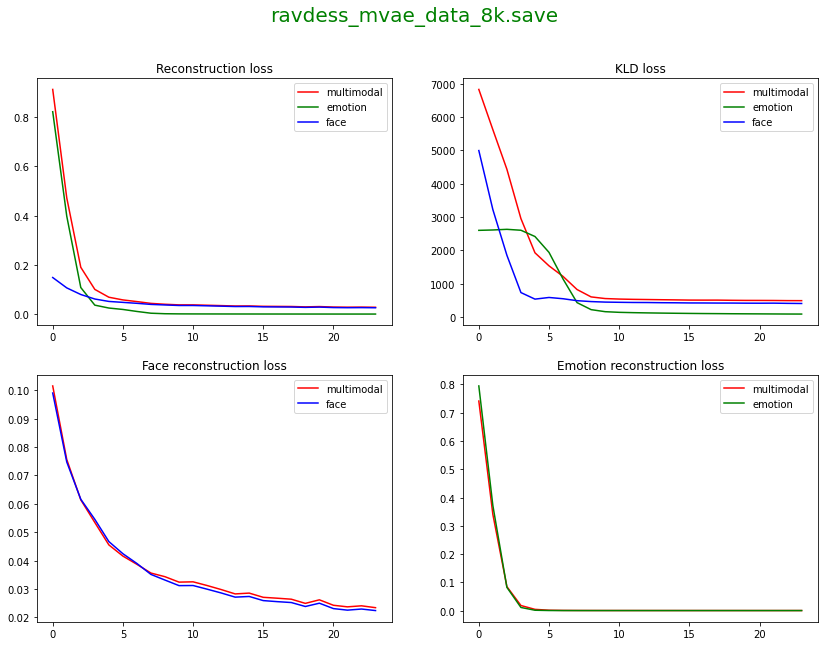

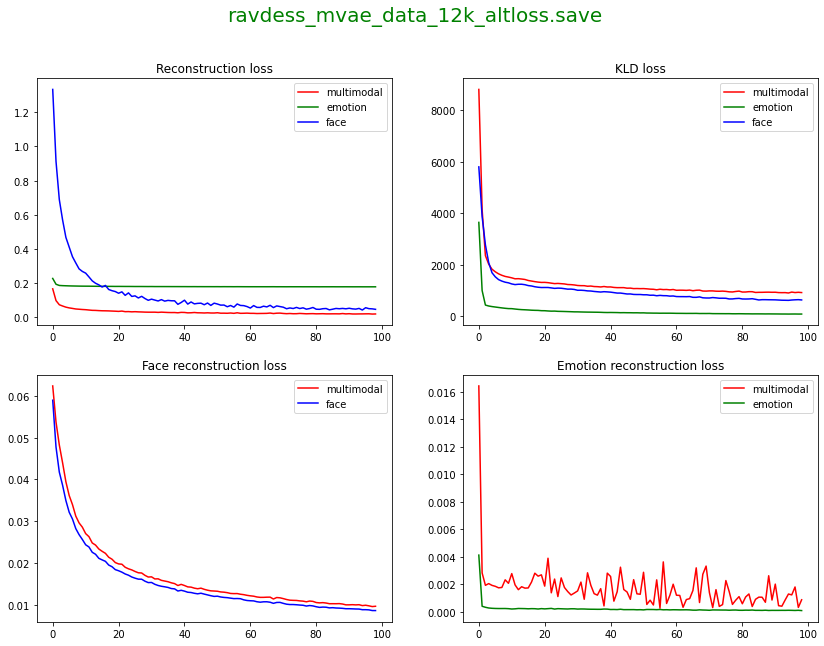

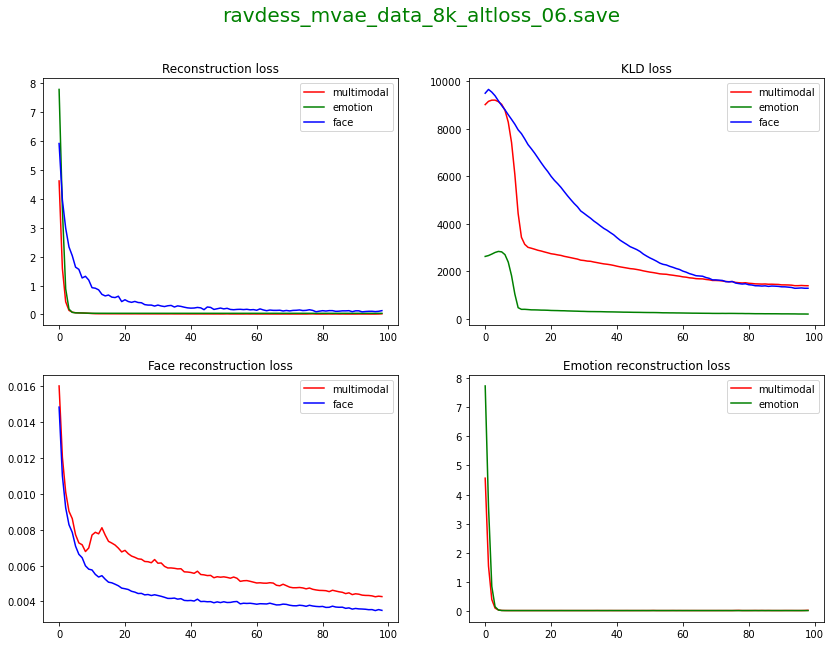

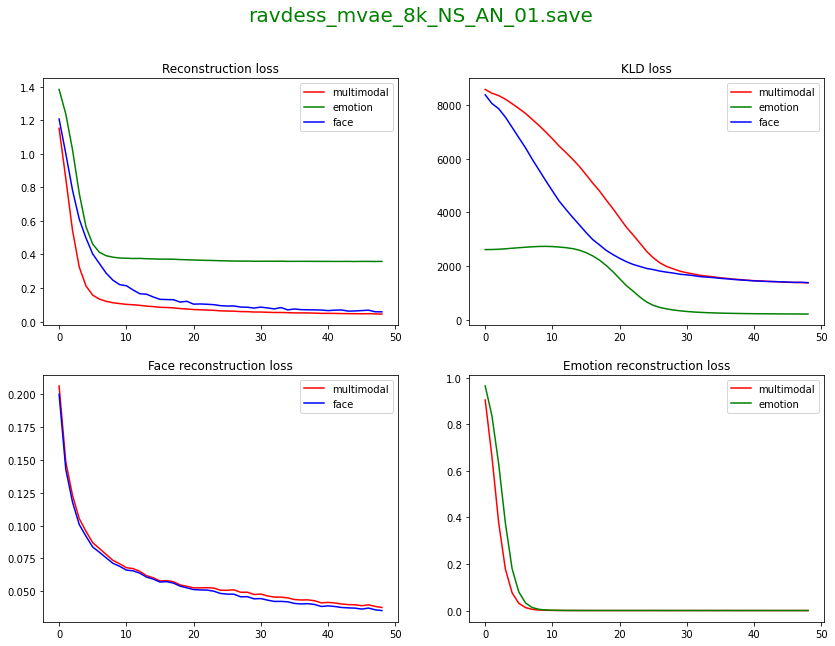

In [14]:
for model_name in model_names:
    loaded_data = torch.load(folder_path + model_name)
    losses = loaded_data['training_loss']
    model_args = loaded_data['model_args']
    print('KLD: ',model_name,' ', losses['multimodal_loss'].kld_loss[-1], ' ', losses['face_loss'].kld_loss[-1], ' ', losses['emotion_loss'].kld_loss[-1])
    print(model_args)
    
    U.print_losses(losses , model_name, 1)

In [7]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 80
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  5760 
test set size:  1440


['happy', 'neutral', 'fearful', 'calm']
['angry', 'happy', 'calm', 'neutral']


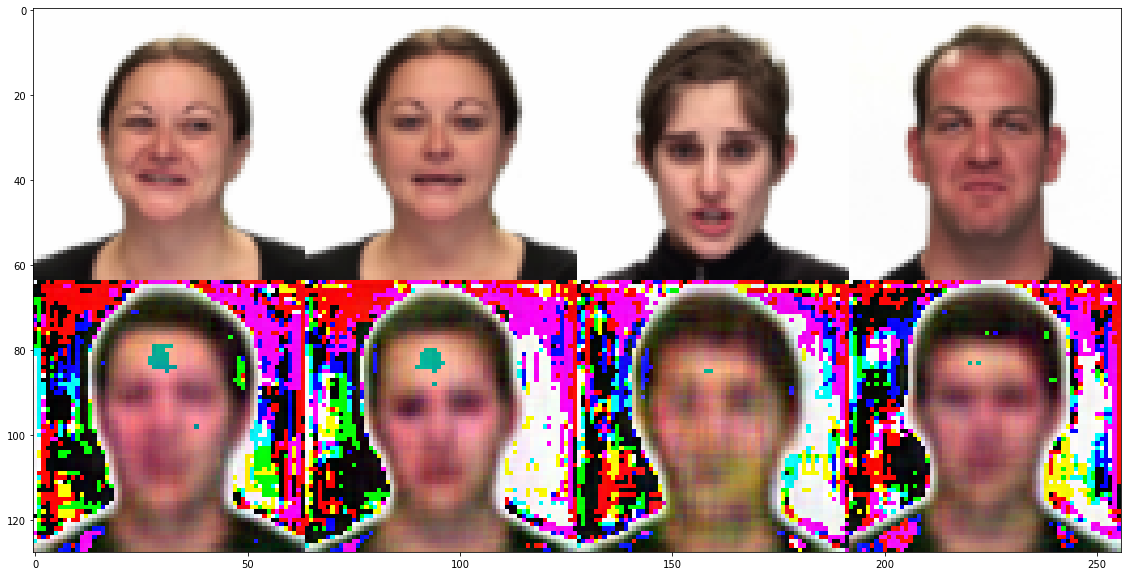

In [8]:
loaded_data = torch.load(folder_path + model_names[0])
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

U.test_batch(model, testset_loader)

['neutral', 'surprised', 'angry', 'sad']
['neutral', 'surprised', 'angry', 'sad']


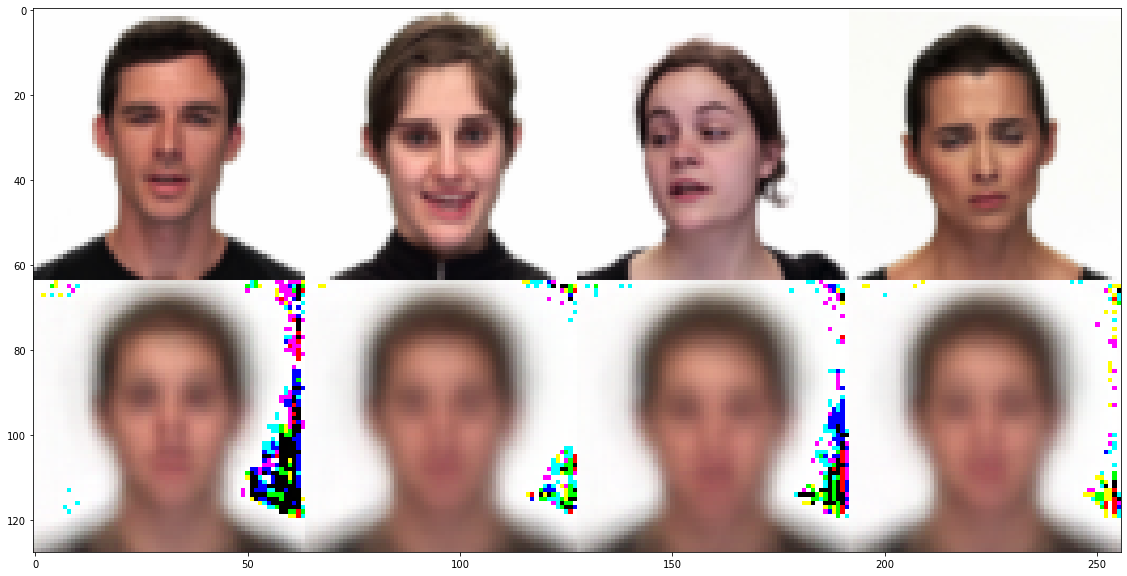

In [9]:
loaded_data = torch.load(folder_path + model_names[1])
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

U.test_batch(model, testset_loader)

['fearful', 'surprised', 'disgust', 'neutral']
['fearful', 'surprised', 'disgust', 'surprised']


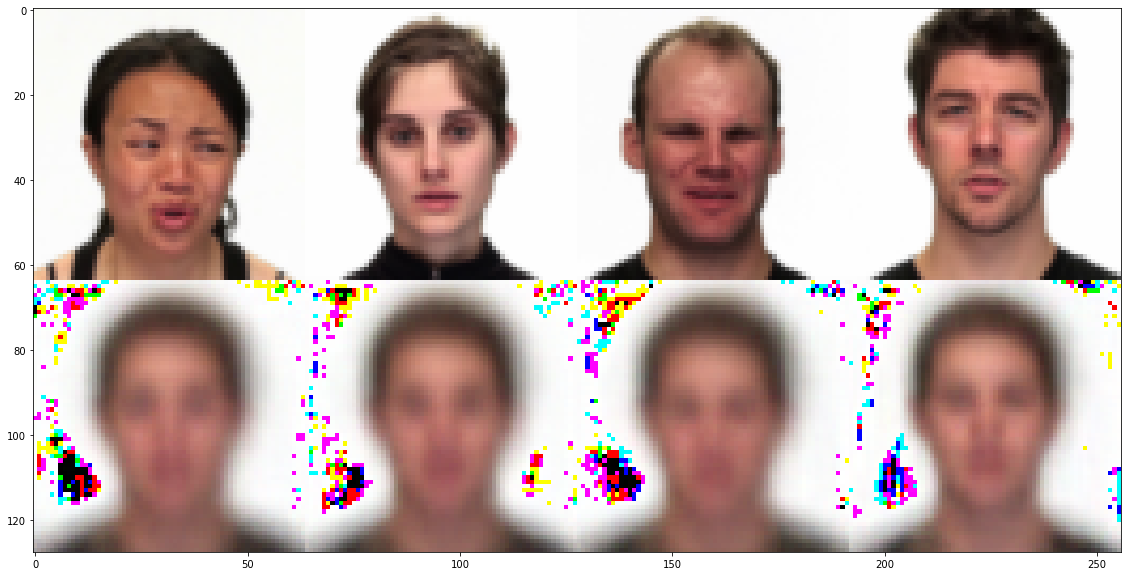

In [10]:
loaded_data = torch.load(folder_path + model_names[2])
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

U.test_batch(model, testset_loader)

In [ ]:
import matplotlib.pyplot as plt
Rd.emocat

In [ ]:
emotion = 2
print(Rd.emocat[emotion])

emotion = torch.tensor([emotion]).to('cuda')
plt.figure(figsize = (5,5))
r_image, _, _, _ = model(faces=None, emotions=emotion)
_, r_emotion, _, _ = model(faces=r_image, emotions=None)
r_image = torch.clamp(r_image, min=0, max=1)
r_image = np.array(r_image.cpu().detach().numpy()[0]).transpose((1, 2, 0))
plt.imshow(r_image)
print((Rd.emocat[torch.argmax(r_emotion.cpu()).item()]))